## Pseudobulk visualization

Now we have all the ingredients we need to generate the pseudobulk files to compare the cell types. With this function we will generate fragments files per group and the corresponding bigwigs in general.

Here, we prepared another function which use the matrix instead of fragments.

In [ ]:
!git clone https://github.com/DBinary/Epiverse.git

Cloning into 'Epiverse'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 463 (delta 23), reused 19 (delta 9), pack-reused 411
Receiving objects: 100% (463/463), 6.14 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [ ]:
!pip install pyranges

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.2 MB/s eta 0:00:00


In [1]:
import omicverse as ov
import scanpy as sc
import Epiverse as ev
ov.utils.ov_plot_set()

## Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of multiome dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD].

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [ ]:
!mkdir data/
!wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad -O data/cd34_multiome_atac.h5ad # ATAC data
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE200nnn/GSE200046/suppl/GSE200046_RAW.tar -O data/GSE200046_RAW.tar
!tar xvf data/GSE200046_RAW.tar

--2023-09-08 15:37:03--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 3.5.25.253, 52.217.168.177, 54.231.137.225, ...
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|3.5.25.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 843871190 (805M) [binary/octet-stream]
Saving to: ‘data/cd34_multiome_atac.h5ad’

data/cd34_multiome_ 100%[===================>] 804.78M  34.3MB/s    in 26s     

2023-09-08 15:37:29 (31.0 MB/s) - ‘data/cd34_multiome_atac.h5ad’ saved [843871190/843871190]

--2023-09-08 15:37:29--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE200nnn/GSE200046/suppl/GSE200046_RAW.tar
           => ‘data/GSE200046_RAW.tar’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.

In [2]:
adata=sc.read('data/cd34_multiome_atac.h5ad')
adata

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'celltype_colors'
    obsm: 'X_svd', 'X_umap'

We require peaks to be expressed in at least 0.01% of the cells.

In [3]:
sc.pp.filter_genes(adata, min_cells = adata.shape[0]*0.01)
adata

filtered out 111070 genes that are detected in less than 68.81 cells


AnnData object with n_obs × n_vars = 6881 × 135043
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'n_cells'
    uns: 'celltype_colors'
    obsm: 'X_svd', 'X_umap'

## Load chromsizes

In order to produce the bigwig files, we also need to know the overall size of the chromosomes. We can easily download this information from the UCSC.

In [4]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

## Analysis the pseudobulk of each celltypes

We provide the `ev.single.pseudobulk` function to get a bigwig file for each cell type from the matrix

In [5]:
!pip install pyrle

In [6]:
!mkdir temp
ev.single.pseudobulk(adata,chromsizes,cluster_key='celltype',
           clusters=['cDC','pDC','CLP'],
           chr=['seqnames','start','end'],
           bigwig_path='temp')

mkdir: cannot create directory ‘temp’: File exists
['cDC', 'pDC', 'CLP']
cDC chr_value
cDC chr_start
cDC chr_end
cDC Name
cDC Score
cDC write
pDC chr_value
pDC chr_start
pDC chr_end
pDC Name
pDC Score
pDC write
CLP chr_value
CLP chr_start
CLP chr_end
CLP Name
CLP Score
CLP write


## Visualization pseudobulk

We can use the bigwig visualisation in the bulk step to analyse the pseudobulk generated by scATAC

In [26]:
bw_dict={
    'cDC':'temp/cDC.bw',
    'pDC':'temp/pDC.bw',
    'CLP':'temp/CLP.bw',
}
bw_obj=ev.bulk.bigwig(bw_dict)
bw_obj.read()

......Loading cDC
......Loading pDC
......Loading CLP


In [27]:
color_dict=dict(zip(adata.obs['celltype'].cat.categories,adata.uns['celltype_colors']))

The gtf files could be downloaded from [gencode](https://www.gencodegenes.org/).

Here, we using GRCh38 v43 to perfrom the annotation.


In [9]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.basic.annotation.gtf.gz

--2023-09-08 16:21:45--  ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.basic.annotation.gtf.gz
           => ‘gencode.v44.basic.annotation.gtf.gz.1’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/gencode/Gencode_human/release_44 ... done.
==> SIZE gencode.v44.basic.annotation.gtf.gz ... 29570410
==> PASV ... done.    ==> RETR gencode.v44.basic.annotation.gtf.gz ... done.
Length: 29570410 (28M) (unauthoritative)

gencode.v44.basic.a 100%[===================>]  28.20M  10.7MB/s    in 2.6s    

2023-09-08 16:21:49 (10.7 MB/s) - ‘gencode.v44.basic.annotation.gtf.gz.1’ saved [29570410]



In [28]:
bw_obj.load_gtf('/content/gencode.v44.basic.annotation.gtf.gz')

......Loading gtf file


In [35]:
region_dict={
    'region1':[125500000, 125500000+500000],
}

(<Figure size 480x192 with 4 Axes>,
 array([<AxesSubplot: ylabel='cDC'>, <AxesSubplot: ylabel='pDC'>,
        <AxesSubplot: ylabel='CLP'>, <AxesSubplot: >], dtype=object))

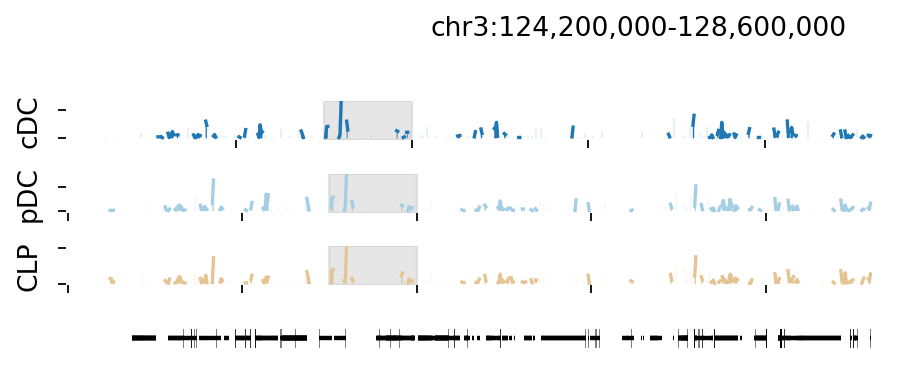

In [36]:
bw_obj.plot_track(chrom='chr3',chromstart=124200000,chromend=128600000,
                  plot_names=['cDC','pDC','CLP'],figwidth=6,figheight=0.6,
                  color_dict=color_dict,
                  region_dict=region_dict
                 )

## Visualization pseudobulk with fragment

We can use the bigwig visualisation in the bulk step to analyse the pseudobulk generated by scATAC and fragment, the fragment files can help us generate th pseudobulk result accurately.

In [12]:
import pandas as pd
fragment_2 = pd.read_csv('/content/GSM6005305_BM_CD34_Rep2_atac_fragments.tsv.gz',sep='\t')
fragment_2

,chr1,10073,10327,CCGCACACAGAAATGC-1,1
0,chr1,10084,10285,CCACAGGGTGAACAAA-1,1
1,chr1,10084,10340,TCTCCTCGTTAGGTTG-1,1
2,chr1,10085,10278,CTCGACAAGTGAGCGG-1,1
3,chr1,10085,10320,AGTTATGTCGGTTTCC-1,2
4,chr1,10085,10327,CTTCAATTCGTTTCGC-1,5
...,...,...,...,...,...
200568152,KI270713.1,37661,37875,TGAGCTTAGGCTGGCT-1,1
200568153,KI270713.1,37663,37882,TCAGCAAGTCATGCCC-1,1
200568154,KI270713.1,38991,39208,CGATTCCTCAGGTTTA-1,3
200568155,KI270713.1,39071,39228,GTGCACGGTCACCTAT-1,1


In [13]:
adata.obs['barcode']=adata.obs.index
for i in adata.obs.index:
  adata.obs.loc[i,'barcode'] = adata.obs.loc[i,'barcode'].split('#')[1]
adata.obs.index = adata.obs['barcode']

In [14]:
adata.obs.loc[adata.obs.index.isin(set(fragment_2.iloc[:,3])), 'type'] = "cd34_multiome_rep2"
adata.obs

,Sample,TSSEnrichment,ReadsInTSS,ReadsInPromoter,ReadsInBlacklist,PromoterRatio,PassQC,NucleosomeRatio,nMultiFrags,nMonoFrags,...,BlacklistRatio,Clusters,ReadsInPeaks,FRIP,leiden,phenograph,celltype,SEACell,barcode,type
barcode,,,,,,,,,,,,,,,,,,,,,
AAACAGCCACTCGCTC-1,cd34_multiome_rep1,10.131,6559,7086,227,0.186062,1,1.015666,2757,9447,...,0.005961,C8,12388,0.654204,3,5,HMP,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,AAACAGCCACTCGCTC-1,cd34_multiome_rep2
AAACAGCCACTGACCG-1,cd34_multiome_rep1,9.216,6381,7340,239,0.154260,1,1.373404,3747,10024,...,0.005023,C13,12880,0.639777,0,2,DCPre,cd34_multiome_rep1#TTGCAGCCAGGCGATA-1,AAACAGCCACTGACCG-1,cd34_multiome_rep2
AAACAGCCATAATCAC-1,cd34_multiome_rep1,11.886,5264,5476,143,0.222638,1,1.149624,1899,5721,...,0.005814,C5,8390,0.731218,5,0,HSC,cd34_multiome_rep1#TACAGCTAGTAATCCA-1,AAACAGCCATAATCAC-1,cd34_multiome_rep2
AAACATGCAAATTCGT-1,cd34_multiome_rep1,12.290,7994,8203,214,0.231266,1,1.431784,3004,7293,...,0.006033,C5,10992,0.749591,4,0,HSC,cd34_multiome_rep2#TAACCTAAGGATTGAG-1,AAACATGCAAATTCGT-1,cd34_multiome_rep2
AAACATGCAGCATGTC-1,cd34_multiome_rep1,9.746,8067,8928,293,0.168218,1,1.517742,4481,10540,...,0.005521,C1,13298,0.627383,7,6,Ery,cd34_multiome_rep1#TAGCGGCTCATTATGG-1,AAACATGCAGCATGTC-1,cd34_multiome_rep2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCTAGGGCCACT-1,cd34_multiome_rep2,9.709,10267,11241,377,0.163753,1,1.138771,5234,16048,...,0.005492,C1,18997,0.589639,7,6,Ery,cd34_multiome_rep1#TAGCGGCTCATTATGG-1,TTTGTCTAGGGCCACT-1,cd34_multiome_rep2
TTTGTGAAGGAAGCAC-1,cd34_multiome_rep2,10.617,5147,5139,134,0.211813,1,1.447740,2023,4956,...,0.005523,C5,7285,0.731867,6,0,HSC,cd34_multiome_rep1#TACAGCTAGTAATCCA-1,TTTGTGAAGGAAGCAC-1,cd34_multiome_rep2
TTTGTGAAGTAACCAC-1,cd34_multiome_rep2,12.637,9464,9801,203,0.222770,1,1.230808,3482,9861,...,0.004614,C6,14692,0.742020,5,5,HSC,cd34_multiome_rep1#GCAGGCTTCAAACACC-1,TTTGTGAAGTAACCAC-1,cd34_multiome_rep2


In [15]:
fragments_dict = {'cd34_multiome_rep1': '/content/GSM6005303_BM_CD34_Rep1_atac_fragments.tsv.gz',
          'cd34_multiome_rep2': '/content/GSM6005305_BM_CD34_Rep2_atac_fragments.tsv.gz'}

In [ ]:
ev.single.pseudobulk_with_fragments(
    input_data = adata.obs,
    chromsizes = chromsizes,
    cluster_key = 'celltype',
    clusters = ['cDC','pDC','CLP'],
    bed_path = 'result/pseudobulk_bed_files/',
    bigwig_path = 'result/pseudobulk_bw_files/',
    verbose = True,
    path_to_fragments = fragments_dict,
    sample_id_col = 'type'
)

In [37]:
bw_dict={
    'cDC':'result/pseudobulk_bw_files/cDC.bw',
    'pDC':'result/pseudobulk_bw_files/pDC.bw',
    'CLP':'result/pseudobulk_bw_files/CLP.bw',
}
bw_obj=ev.bulk.bigwig(bw_dict)
bw_obj.read()

......Loading cDC
......Loading pDC
......Loading CLP


In [38]:
color_dict=dict(zip(adata.obs['celltype'].cat.categories,adata.uns['celltype_colors']))

In [39]:
bw_obj.load_gtf('/content/gencode.v44.basic.annotation.gtf.gz')

......Loading gtf file


(<Figure size 480x192 with 4 Axes>,
 array([<AxesSubplot: ylabel='cDC'>, <AxesSubplot: ylabel='pDC'>,
        <AxesSubplot: ylabel='CLP'>, <AxesSubplot: >], dtype=object))

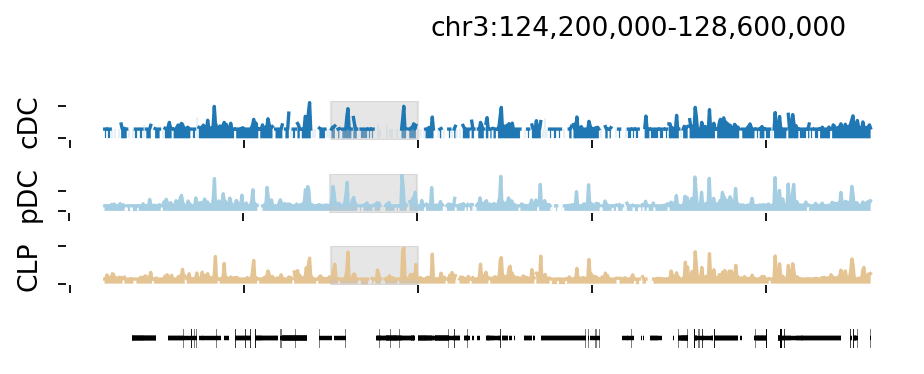

In [41]:
bw_obj.plot_track(chrom='chr3',chromstart=124200000,chromend=128600000,
                  plot_names=['cDC','pDC','CLP'],figwidth=6,figheight=0.6,
                  color_dict=color_dict,
                  region_dict=region_dict
                 )